In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image
import torch
import torchmetrics
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pprint import pformat
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import Subset, random_split
from torchvision.datasets.utils import download_url, extract_archive

# Download dataset

In [2]:
root = './'
filename = 'data.zip'
archive = os.path.join(root, filename)
url = 'https://sid.erda.dk/share_redirect/heaAFNnmaG/data.zip'
data_folder = os.path.join(root, 'data/images')
force_download = False
if (not os.path.exists(data_folder) or force_download):
    download_url(url, root, filename)
    extract_archive(archive, './data', False)

In [3]:
def imshow(img):
    plt.figure()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

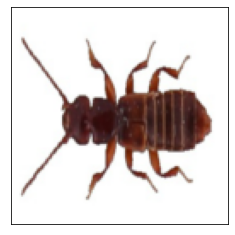

In [4]:
img_height = 128
img_width = img_height
resize_transform = transforms.Resize((img_height, img_width))
pil_transforms = transforms.Compose(
    [resize_transform, transforms.ToTensor()]
)

dataset = datasets.ImageFolder(data_folder, transform=pil_transforms)
image, label = dataset[0]
imshow(image)


# Split dataset into train, validation and test sets

In [5]:
train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - (train_len + val_len)
dataset_lengths = [train_len, val_len, test_len]
train_data, val_data, test_data = random_split(dataset, dataset_lengths)
num_workers = 0
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                            num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            num_workers=num_workers)

In [11]:
iterable = iter(train_loader)
images, labels = next(iterable)
imshow(images[0])